# Emittance minimization using Xopt with BAXGenerator running algorithm ScipyMinimizeEmittance

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BAXGenerator

from xopt.evaluator import Evaluator

from xopt.generators.bayesian.bax.utils import (post_path_emit, compute_emits_from_batched_beamsize_scans, 
                                                get_meas_scan_inputs_from_tuning_configs, get_valid_emittance_samples)
from xopt.generators.bayesian.bax.sampling import draw_product_kernel_post_paths, compare_sampling_methods
from xopt.generators.bayesian.bax.algorithms import ScipyMinimizeEmittance

import time
import numpy as np
import random

In [2]:
if torch.cuda.is_available():
# if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    use_cuda = True
else:
    use_cuda = False

# Notebook settings

In [3]:
ndim = 2 #number of input dimensions
noise = False
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 3 #number of random initial observations for GP model
n_samples = 20 #number of posterior samples for BAX
n_iter = 20 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 0

# Construct vocs

In [4]:
#construct vocs
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]
variables = {var_name: [-3,1] for var_name in var_names}
variables[meas_param] = [-40,40] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

vocs = VOCS(
    variables = variables,
    objectives = {'y':"MINIMIZE"}
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
meas_param = 'x1'
domain =
 [[ -3.   1.]
 [-40.  40.]]


# Build test function from single-quadrupole optical beam size model 

In [5]:
# define test functions
distance = torch.tensor(2.26).double()
q_len = torch.tensor(0.108).double()
s11 = torch.tensor(3e-6).double()
s12 = torch.tensor(1.5e-6).double()
s22 = torch.tensor(2e-6).double()
gt_min_emit = torch.sqrt(s11 * s22 - s12 ** 2)*1e6
print('Ground-Truth Minimum Emittance:', gt_min_emit.item())



def beam_size_squared(k, d, l, s11, s12, s22):
    return (
        (1.0 + k * d * l) ** 2 * s11 + 2.0 * (1.0 + d * l * k) * d * s12 + d ** 2 * s22
    )
    
def toy_beam_size_squared_nd(x, meas_dim, noise=noise):
    
    tuning_dims = list(range(x.shape[-1]))
    tuning_dims.remove(meas_dim)
    emit = torch.sqrt(s11 * s22 - s12 ** 2)
    bss = ((1 + torch.sum(x[:,tuning_dims]**2, dim=1) )* beam_size_squared(x[:,meas_dim], distance, q_len, s11, s12, s22)).reshape(-1,1) 
    bss *= 1.e6
    if noise:
        bss *= (1 + 0.05*torch.rand_like(bss))      
    return bss

def toy_emit_nd(X_tuning):
    return (1 + torch.sum(X_tuning**2, dim=1) ) * gt_min_emit

def test_func(input_dict):
    x = torch.tensor(input_dict[meas_param]).reshape(-1,1)
    for key in input_dict.keys():
        if key is not meas_param:
            x = torch.cat((x, torch.tensor(input_dict[key]).reshape(-1,1)), dim=1)
    return {'y': toy_beam_size_squared_nd(x, 0).squeeze().cpu().numpy()}

Ground-Truth Minimum Emittance: 1.9364916731037083


# Optimize

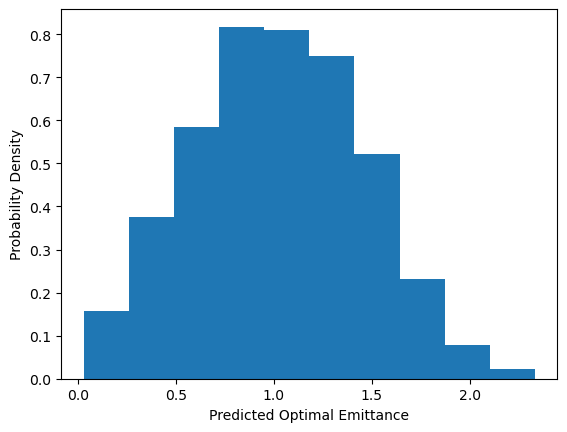

sample validity rate: tensor([0.5033])
Iteration: 1 / 20
get_acquisition() took 1.3132336139678955 seconds.
optimize_acqf() took 3.8341946601867676 seconds.
This iteration took: 5.652226686477661 seconds.

Iteration: 2 / 20
get_acquisition() took 0.6143171787261963 seconds.
optimize_acqf() took 0.018963098526000977 seconds.
This iteration took: 0.6632003784179688 seconds.

Iteration: 3 / 20
get_acquisition() took 0.6537644863128662 seconds.
optimize_acqf() took 0.38262224197387695 seconds.
This iteration took: 1.101522445678711 seconds.

Iteration: 4 / 20
get_acquisition() took 0.5576004981994629 seconds.
optimize_acqf() took 0.3549518585205078 seconds.
This iteration took: 1.1069920063018799 seconds.

Iteration: 5 / 20
get_acquisition() took 0.656130313873291 seconds.
optimize_acqf() took 3.6759421825408936 seconds.
This iteration took: 4.400879621505737 seconds.



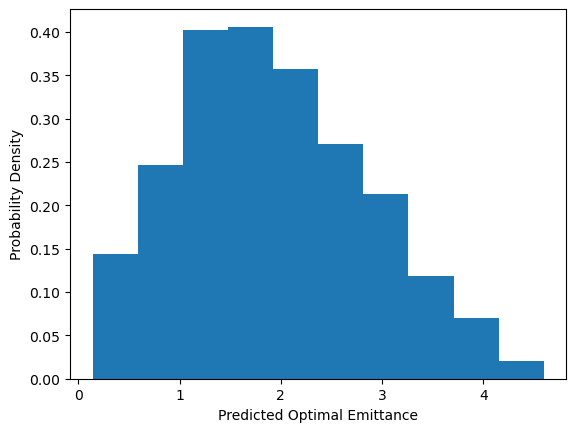

sample validity rate: tensor([0.0548])
Iteration: 6 / 20
get_acquisition() took 0.34848666191101074 seconds.
optimize_acqf() took 0.5339748859405518 seconds.
This iteration took: 0.9370415210723877 seconds.

Iteration: 7 / 20
get_acquisition() took 0.6113052368164062 seconds.
optimize_acqf() took 6.08197546005249 seconds.
This iteration took: 6.74115777015686 seconds.

Iteration: 8 / 20
get_acquisition() took 0.8230023384094238 seconds.
optimize_acqf() took 10.296974420547485 seconds.
This iteration took: 11.239388465881348 seconds.

Iteration: 9 / 20
get_acquisition() took 1.018427848815918 seconds.
optimize_acqf() took 3.4155399799346924 seconds.
This iteration took: 4.612017393112183 seconds.

Iteration: 10 / 20
get_acquisition() took 0.6668808460235596 seconds.
optimize_acqf() took 2.9674227237701416 seconds.
This iteration took: 3.7405264377593994 seconds.



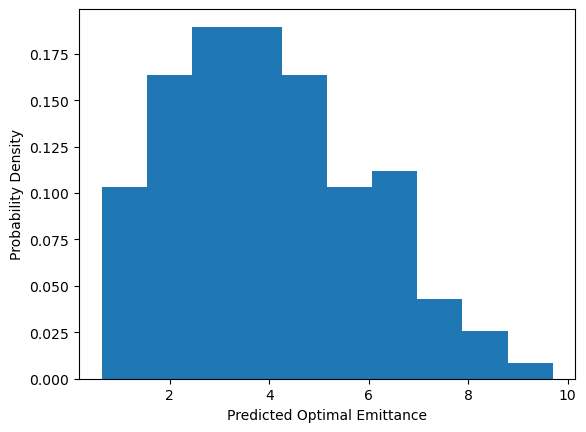

sample validity rate: tensor([0.0128])
Iteration: 11 / 20
get_acquisition() took 0.5909934043884277 seconds.
optimize_acqf() took 2.4016647338867188 seconds.
This iteration took: 3.115751266479492 seconds.

Iteration: 12 / 20
get_acquisition() took 0.6788794994354248 seconds.
optimize_acqf() took 2.719846487045288 seconds.
This iteration took: 3.5669946670532227 seconds.

Iteration: 13 / 20
get_acquisition() took 0.8771083354949951 seconds.
optimize_acqf() took 5.371395111083984 seconds.
This iteration took: 6.435940742492676 seconds.

Iteration: 14 / 20
get_acquisition() took 0.9749457836151123 seconds.
optimize_acqf() took 2.9051053524017334 seconds.
This iteration took: 4.208981037139893 seconds.

Iteration: 15 / 20
get_acquisition() took 1.0283043384552002 seconds.
optimize_acqf() took 2.0728118419647217 seconds.
This iteration took: 3.2686948776245117 seconds.



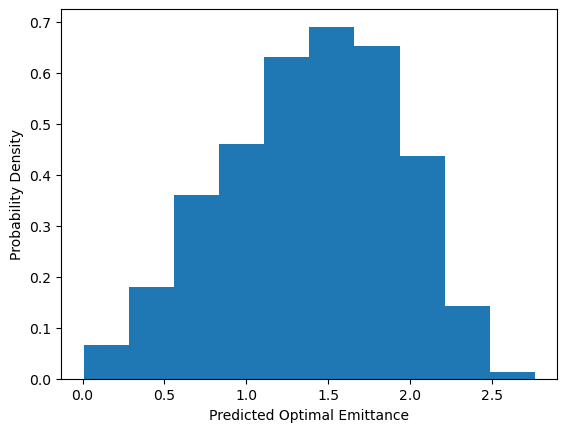

sample validity rate: tensor([0.5075])
Iteration: 16 / 20
get_acquisition() took 1.412602424621582 seconds.
optimize_acqf() took 2.8600521087646484 seconds.
This iteration took: 4.416555166244507 seconds.

Iteration: 17 / 20
get_acquisition() took 0.838817834854126 seconds.
optimize_acqf() took 6.519610643386841 seconds.
This iteration took: 7.560795068740845 seconds.

Iteration: 18 / 20
get_acquisition() took 1.201815128326416 seconds.
optimize_acqf() took 4.854913949966431 seconds.
This iteration took: 6.270013332366943 seconds.

Iteration: 19 / 20
get_acquisition() took 0.8689093589782715 seconds.
optimize_acqf() took 2.3314898014068604 seconds.
This iteration took: 3.464606285095215 seconds.

Iteration: 20 / 20
get_acquisition() took 1.225365400314331 seconds.
optimize_acqf() took 4.0138771533966064 seconds.
This iteration took: 5.504002809524536 seconds.



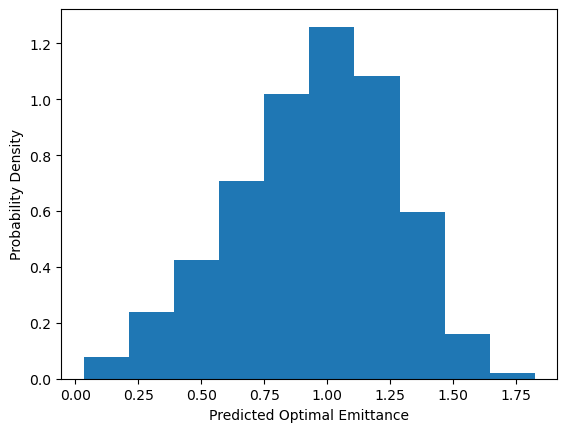

sample validity rate: tensor([0.8691])


In [6]:
#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

#Prepare Algorithm
algo_class = ScipyMinimizeEmittance
algo_kwargs = {'domain': vocs.bounds.T, #shape (ndim, 2) tensor domain[i,0], domain[i,1] are lower, upper bound respectively for ith input dimension. 
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 10,
        'n_steps_exe_paths':  10}


generator = BAXGenerator(vocs, meas_param, algo_class, algo_kwargs)
          
    
evaluator = Evaluator(function=test_func)


optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
optimizer.generator.options.n_initial = n_obs_init #set number of initial observations
optimizer.generator.options.use_cuda = use_cuda #set number of initial observations



# call X.step() to generate random initial points and evaluate on test_func
optimizer.step()    



#get initial emittance prediction at ground truth optimum
beam_size_model = optimizer.generator.train_model().models[0]


#get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
X_tuned, emits_at_target_valid, emits_sq_at_target, is_valid, svr = optimizer.generator.algo.mean_output(beam_size_model, num_restarts=10)


plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
plt.xlabel('Predicted Optimal Emittance')
plt.ylabel('Probability Density')
plt.show()
print('sample validity rate:', svr)

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP model hyperparams
    beam_size_model = optimizer.generator.model.models[0]

    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    X_tuned, emits_at_target_valid, emits_sq_at_target, is_valid, svr = optimizer.generator.algo.mean_output(beam_size_model, num_restarts=10)
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

    if i % 5 == 0:
        plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
        plt.xlabel('Predicted Optimal Emittance')
        plt.ylabel('Probability Density')
        plt.show()
        print('sample validity rate:', svr)

torch.Size([6400, 2])
torch.Size([6400, 2])
torch.Size([6400, 2])


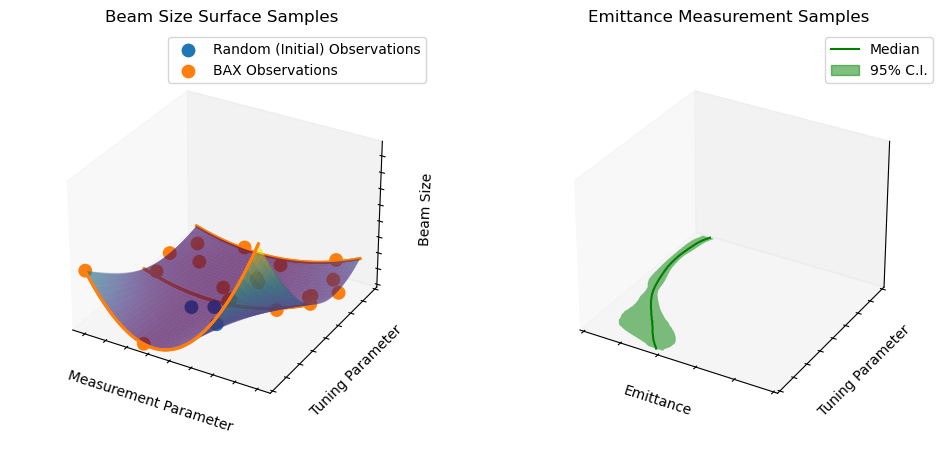

In [7]:
if ndim==2:
    
    device = torch.tensor(1).device
    torch.set_default_tensor_type('torch.DoubleTensor')

    fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
    fig.set_size_inches(12,12)

    ax = axs[0]

    for s in range(3):

        xlin, ylin = torch.arange(-3,1,0.05), torch.arange(-40,40, 1.)
        X, Y = torch.meshgrid(xlin, ylin)
        XY = torch.cat((X.reshape(-1,1), Y.reshape(-1,1)), dim=1)
        print(XY.shape)
        Z = optimizer.generator.algo.post_paths_cpu(XY)[s].reshape(X.shape).detach()

        cmap='viridis'
        surf = ax.plot_surface(Y, X, Z, cmap=cmap,
                               linewidth=0, antialiased=True, alpha=0.3)


        ax.plot(Y[0,:].numpy(), Z[0,:].numpy(), zs=X[0,0].item(), zdir='y', c='C1', lw=2, zorder=10)
        ax.plot(Y[int(len(Z[0,:])/2),:].numpy(), Z[int(len(Z[0,:])/2),:].numpy(), zs=X[int(len(Z[0,:])/2),0].item(), zdir='y', c='C1', lw=2)
        ax.plot(Y[-1,:].numpy(), Z[-1,:].numpy(), zs=X[-1,0].item(), zdir='y', c='C1', lw=2)





    x0 = torch.tensor(optimizer.data['x0'].values)[:n_obs_init]
    x1 = torch.tensor(optimizer.data['x1'].values)[:n_obs_init]
    y = torch.tensor([item.item() for item in optimizer.data['y'].values])[:n_obs_init]
    ax.scatter(x1.flatten(), x0.flatten(), y.flatten(), marker='o', c='C0', alpha=1, s=80, label='Random (Initial) Observations', zorder=15)

    x0 = torch.tensor(optimizer.data['x0'].values)[n_obs_init:]
    x1 = torch.tensor(optimizer.data['x1'].values)[n_obs_init:]
    y = torch.tensor([item.item() for item in optimizer.data['y'].values])[n_obs_init:]
    ax.scatter(x1.flatten(), x0.flatten(), y.flatten(), marker='o', c='C1', alpha=1, s=80, label='BAX Observations', zorder=15)

    ax.set_title('Beam Size Surface Samples')
    ax.set_ylabel('Tuning Parameter')
    ax.set_xlabel('Measurement Parameter')
    ax.set_zlabel('Beam Size')

    ax.set_ylim(-3, 1)
    ax.set_zlim(0)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    ax.legend()
    ax.dist = 12

    
    
    if device.type == "cuda":
        torch.set_default_tensor_type("torch.cuda.DoubleTensor")
        
   

    emit_lowers = torch.tensor([])
    emit_uppers = torch.tensor([])
    emit_meds = torch.tensor([])
    for tuning_param in xlin:
        X_tuning = tuning_param.reshape(1,-1).to(device)
        emits, emits_sq_all, is_valid, svr = get_valid_emittance_samples(beam_size_model, vocs.bounds.T, meas_dim, X_tuning, n_samples=10000, n_steps_quad_scan=10)
        emit_lower = torch.quantile(emits, q=0.025, dim=0)
        emit_upper = torch.quantile(emits, q=0.975, dim=0)
        emit_med = torch.quantile(emits, q=0.5, dim=0)

        emit_lowers = torch.cat((emit_lowers, emit_lower))
        emit_uppers = torch.cat((emit_uppers, emit_upper))
        emit_meds = torch.cat((emit_meds, emit_med))


    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    import matplotlib.patches as mpatches

    ax = axs[1]
    
    medline, = ax.plot(emit_meds.cpu().numpy(), xlin.numpy(), zs=0, zdir='z', c='g', label='Median')
    
    verts = (
        [(emit_lowers[i].item(), xlin[i].item(), 0) for i in range(len(xlin))] + 
        [(emit_uppers[i].item(), xlin[i].item(), 0) for i in range(len(xlin))][::-1]
    )
    ax.add_collection3d(Poly3DCollection([verts],color='g', edgecolor='None', alpha=0.5)) # Add a polygon instead of fill_between

    
    ax.set_xlabel('Emittance')
    ax.set_ylabel('Tuning Parameter')
    ax.set_title('Emittance Measurement Samples')
    
    ax.set_xlim(0,25)
    ax.set_ylim(-3,1)
    ax.set_zlim(0,1)

    ax.set_zticks([])

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    orange_patch = mpatches.Patch(color='g', alpha=0.5, label='95% C.I.')
    ax.legend(handles=[medline, orange_patch])
    ax.dist = 12

    plt.tight_layout()
#             plt.savefig('beamsize-surfaces-with-emittance.svg', format='svg')
    plt.show()


# Inspect current Acquisition Function and compare to most recently acquired observation

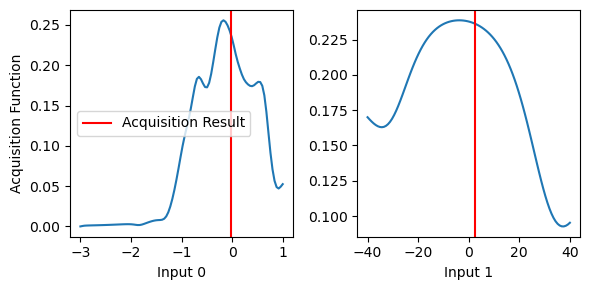

In [8]:
acq = optimizer.generator.get_acquisition(optimizer.generator._model)

last_acq = np.vstack(optimizer.data.iloc[-1][list(vocs.variable_data([vocs.random_inputs()], '').keys())].values[:]).astype(float)
last_acq = torch.tensor(last_acq).reshape(1,-1)

fig, axs = plt.subplots(1, ndim)
    
fig.set_size_inches(3*(ndim), 3)

for scan_dim in range(ndim):
    X_scan = last_acq.repeat(100,1)
    ls = torch.linspace(*vocs.bounds.T[scan_dim],100)

    X_scan[:,scan_dim] = ls

    acq_scan = torch.tensor([acq(X.reshape(1,-1)) for X in X_scan]).reshape(-1)
    
    ax = axs[scan_dim]
    
    ax.plot(ls.cpu(), acq_scan.detach().cpu())
    ax.axvline(last_acq[0,scan_dim].cpu(), c='r', label='Acquisition Result')
    
    
    ax.set_xlabel('Input ' + str(scan_dim))
    
    if scan_dim == 0:
        ax.set_ylabel('Acquisition Function')
        ax.legend()
    
plt.tight_layout()
plt.show()

# Minimize sample emittance functions produced by current GP beam size model and inspect results

In [9]:
#minimize sample emittances (by calling get_exe_paths) and time it
start = time.time()
X_sample_opt = optimizer.generator.algo.get_sample_minima(model = beam_size_model)[0]
end = time.time()
print('get_sample_minima() took', end-start, 'seconds.')



print('Average x_tuned =', torch.mean(X_tuned, dim=0))

get_sample_minima() took 1.0184664726257324 seconds.
Average x_tuned = tensor([0.0408])


In [10]:
#select sample result

sid = 10 #sample index to examine

X_tuned = X_sample_opt[sid].reshape(1,-1)
print('X_tuned =', X_tuned)

X_tuned = tensor([[-0.1463]])


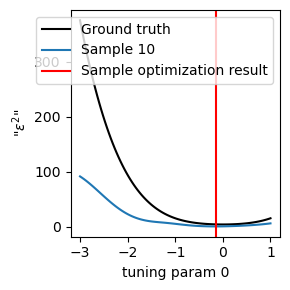

In [11]:
#plot sample emittance minimization result

fig, axs = plt.subplots(1, ndim-1)
if ndim == 2: axs = [axs]
    
fig.set_size_inches(3*(ndim-1), 3)

for scan_dim in range(ndim-1):
    X_tuning_scan = X_tuned.repeat(100,1)
    ls = torch.linspace(-3,1,100)
    X_tuning_scan[:,scan_dim] = ls
    X_meas = torch.linspace(-40,60,3)

    emits_sq = post_path_emit(optimizer.generator.algo.post_paths_cpu, meas_dim, X_tuning_scan.cpu(), X_meas.cpu(), samplewise=False, squared=True)[0]
        
    ax = axs[scan_dim]
    
    ax.plot(ls.cpu(), (toy_emit_nd(ls.reshape(-1,1))**2).cpu(), c='k', label='Ground truth') #this ground truth isn't exactly the matching cross-section but it should be close

    ax.plot(ls.cpu(), emits_sq[sid].detach().cpu(), label='Sample ' + str(sid))
    ax.axvline(X_tuned[0,scan_dim].cpu(), c='r', label='Sample optimization result')
    
    
    ax.set_xlabel('tuning param ' + str(scan_dim))
    
    if scan_dim == 0:
        ax.set_ylabel('"$\epsilon^{2}$"')
        ax.legend()
    
plt.tight_layout()
plt.show()


# Use current beam size GP model (with ProductKernel: Matern x Polynomial) to compare custom pathwise posterior sampling to BoTorch standard (non-pathwise) posterior sampling

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 99


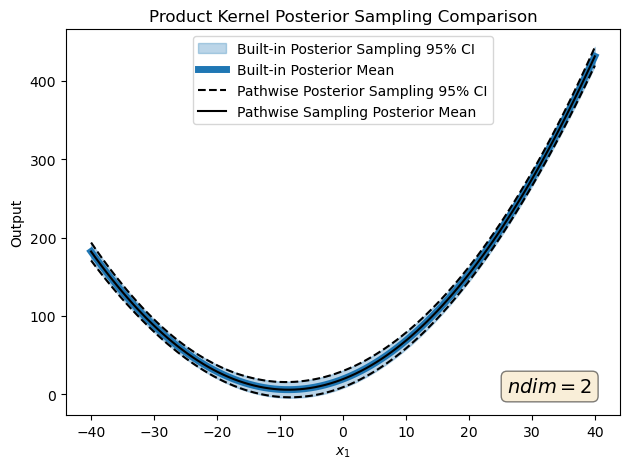

In [12]:
if True:   
    compare_sampling_methods(model = beam_size_model, domain = vocs.bounds.T, scan_dim = 1, n_samples_per_batch = 100, n_batches = 100, verbose = True)
